# British Airways Reviews Analysis

Notebook 1: Data Cleaning and Preprocessing


In [18]:
import pandas as pd
import missingno as msno
from IPython.display import display
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns

In [19]:
df = pd.read_csv(
    "../data/airline_reviews.csv",
)

In [20]:
# rename columns in snake_case, and drop duplicates

df.columns = [col.replace("& ", "").replace(" ", "_").lower() for col in df.columns]

df = df.drop_duplicates()

### Data Overview


In [21]:
# Get a quick overview of our columns, data types and missing values


def dataframe_summary(data):
    summary = pd.DataFrame({
        "Column Name": data.columns,
        "Data Type": data.dtypes,
        "Missing Values": data.isna().sum(),
        "Unique Values": data.nunique(),
    })
    return summary.reset_index(drop=True)


summary_df = dataframe_summary(df)

display(summary_df)
print("Shape: ", df.shape)

,Column Name,Data Type,Missing Values,Unique Values
0,date,object,0,1919
1,rating,object,0,11
2,title,object,0,2802
3,country,object,2,72
4,review,object,0,3811
5,aircraft,object,1816,207
6,type_of_traveller,object,754,4
7,seat_type,object,2,4
8,route,object,758,1597
9,date_flown,object,761,121


Shape:  (3813, 19)


### Visualization of missing values


<Axes: >

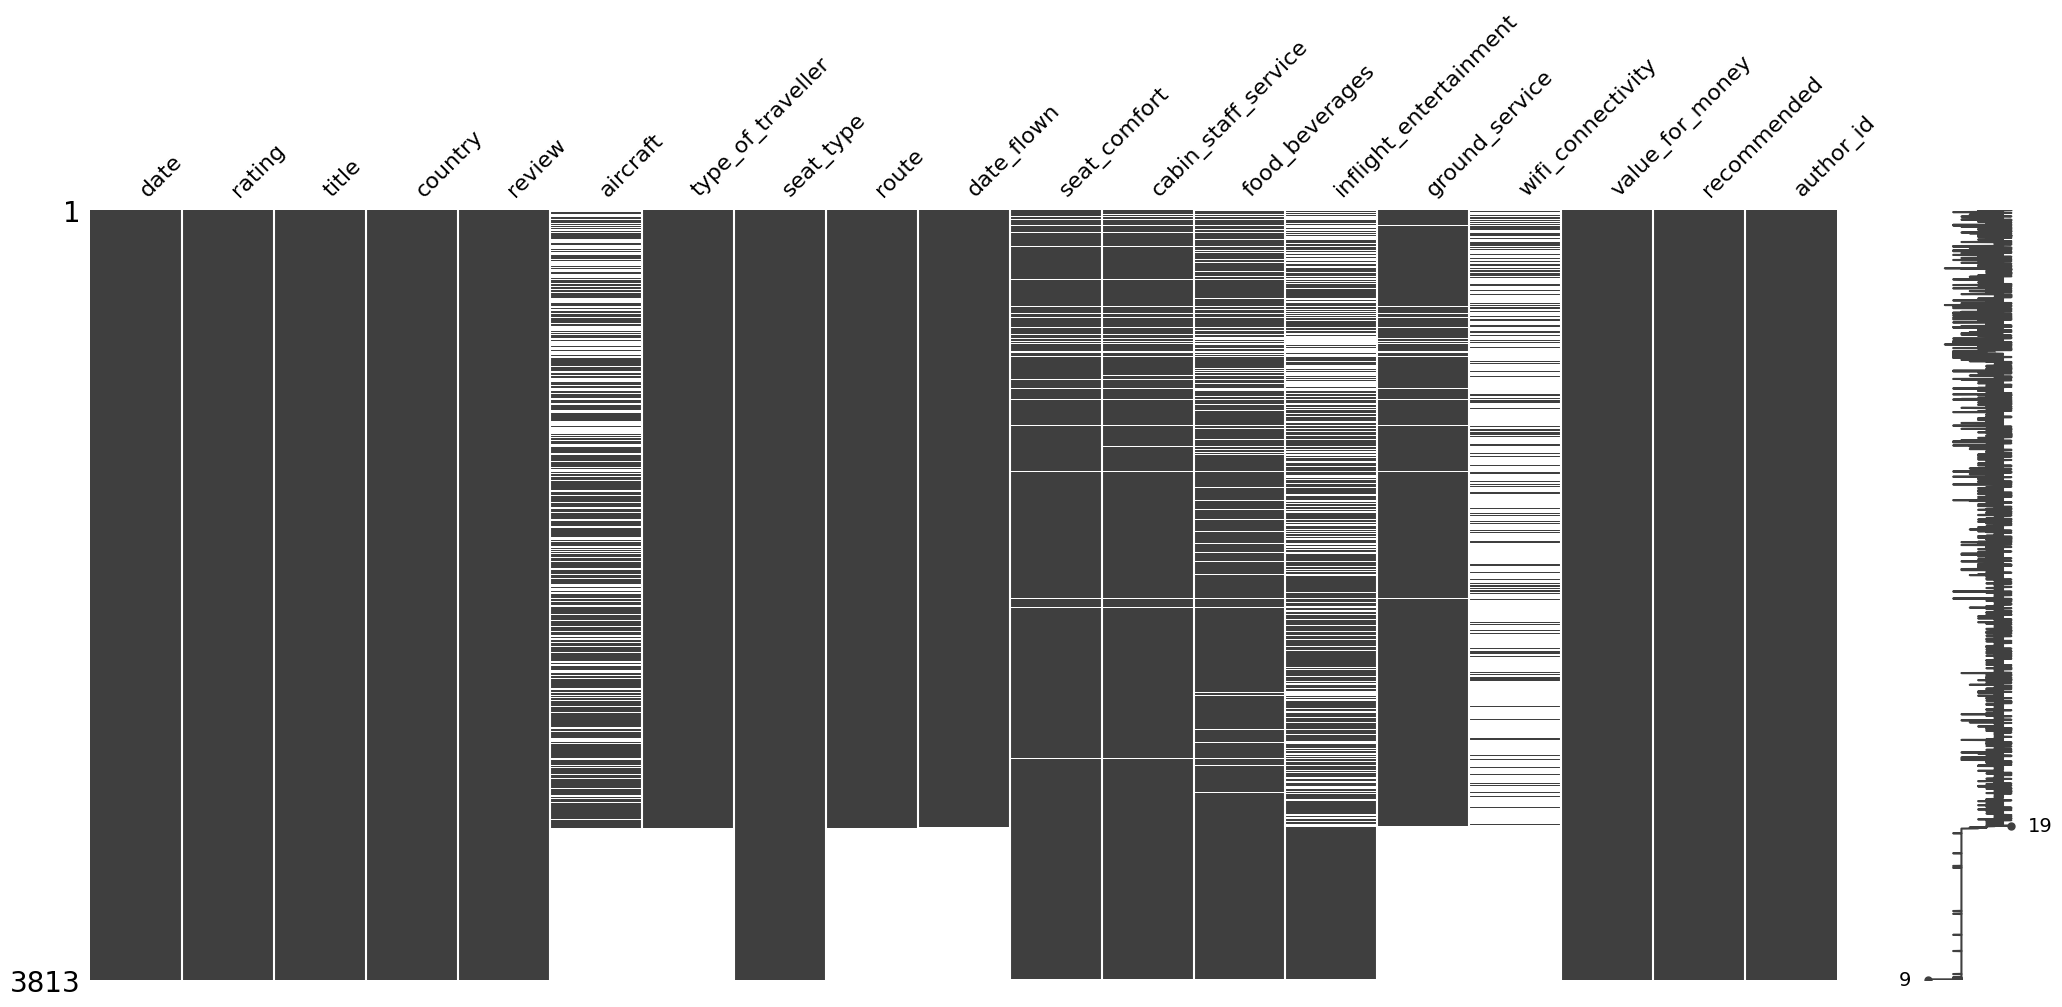

In [22]:
# Visualize Missing Data
msno.matrix(df)

### Clean up ordinal columns


In [23]:
# Convert 'rating' to numeric, replacing 'na' with NaN
# This allows us to perform numerical operations on the rating column
df["rating"] = df["rating"].replace("na", pd.NA)

# These are service aspects that are rated by customers on a 5-star scale
ordinal_columns_5 = [
    "seat_comfort",
    "cabin_staff_service",
    "food_beverages",
    "inflight_entertainment",
    "ground_service",
    "wifi_connectivity",
    "value_for_money",
]

df[ordinal_columns_5] = df[ordinal_columns_5].astype("Int64")
df["rating"] = df["rating"].astype("Int64")

df[ordinal_columns_5] = df[ordinal_columns_5].apply(lambda x: pd.Categorical(x, ordered=True, categories=range(1, 6)))
df["rating"] = pd.Categorical(df["rating"], ordered=True, categories=range(1, 11))

### Extract date components


In [24]:
df["date"] = pd.to_datetime(df["date"])
df["review_date_day"] = df["date"].dt.day
df["review_date_month"] = df["date"].dt.month
df["review_date_year"] = df["date"].dt.year
df = df.drop(columns=["date"])


df[["date_flown_month", "date_flown_year"]] = df["date_flown"].str.split(" ", expand=True)

df["date_flown_month"] = (
    df["date_flown_month"]
    .map({
        "January": 1,
        "February": 2,
        "March": 3,
        "April": 4,
        "May": 5,
        "June": 6,
        "July": 7,
        "August": 8,
        "September": 9,
        "October": 10,
        "November": 11,
        "December": 12,
    })
    .astype("Int64")
)

df["date_flown_year"] = df["date_flown_year"].astype("Int64")
df = df.drop(columns=["date_flown"])

### Set Boolean Data Types


In [25]:
df["recommended"] = df["recommended"].map({"yes": 1, "no": 0}).astype("boolean")

In [26]:
# Clean up review column and extract verified status as new feature

df[["verified", "review_text"]] = df["review"].str.split(r"\s\|\s", n=1, regex=True, expand=True)
df["verified"] = df["verified"].map({"✅ Trip Verified": 1, "Not Verified": 0}).astype("boolean")
df = df.drop(columns=["review"])

### Parse routes


In [27]:
# Parse route information and extract to, from, and layover cities as new features

df[["route_from", "route_to_via"]] = df["route"].str.split(r"\sto\s", n=1, regex=True, expand=True)
df[["route_to", "route_via"]] = df["route_to_via"].str.split(r"\svia\s", n=1, regex=True, expand=True)
df["route_has_layover"] = df["route_via"].notna()

df = df.drop(columns=["route", "route_to_via", "route_via"])

df["route_from"] = df["route_from"].fillna("Unknown")
df["route_to"] = df["route_to"].fillna("Unknown")

df["aircraft"] = df["aircraft"].fillna("Unknown")
df["type_of_traveller"] = df["type_of_traveller"].fillna("Unknown")

### Distribution of Ratings

If there’s a noticeable difference between the rating distribution of unverified and verified reviews, it could suggest the presence of fraudulent reviews.


In [28]:
df["has_review"] = df["review_text"].notna()

fig = px.histogram(
    df, x="rating", color="verified", marginal="box", hover_data=df.columns, title="Ratings by Verified Status"
)
fig.show()

#### Plotting feature ratings with/without written reviews

This gives us insight into how customers rate different aspects of their flight experience and whether they are more likely to write a review if they are dissatisfied.


In [29]:
def plot_feature_ratings(data=df):
    fig = sp.make_subplots(rows=3, cols=3, subplot_titles=ordinal_columns_5)

    for i, col in enumerate(ordinal_columns_5):
        row = i // 3 + 1
        col_index = i % 3 + 1
        hist = px.histogram(
            data,
            x=col,
            color="has_review",
            barmode="group",
            title=col,
        )
        for trace in hist.data:
            # Update legend group to combine the same category traces
            trace.update(showlegend=i == 0)  # Show legend only for the first subplot
            fig.add_trace(trace, row=row, col=col_index)

    fig.update_layout(
        height=700,
        width=900,
        title_text="Distributions of Star-Rated Features",
        legend_title_text="Has Text Review",
    )
    fig.show()


plot_feature_ratings()

### Plot ratings by recommendation

This helps us understand the relationship between overall rating and likelihood to recommend


In [41]:
import plotly.express as px


fig = px.histogram(df, x="rating", color="recommended", marginal="box", title="Distribution of Ratings")
fig.show()

<Figure size 1500x1000 with 0 Axes>

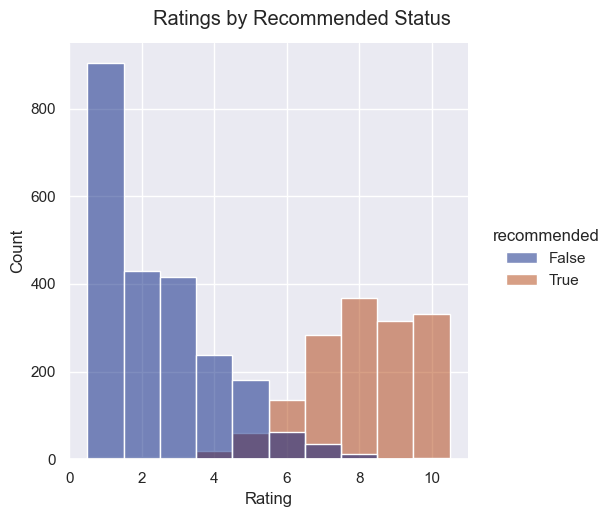

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(15, 10))

# Apply the theme and context to Seaborn
sns.set_theme(
    style="darkgrid",
    palette="dark",
)
sns.set_context(rc={"figure.figsize": (15, 10)})

# Create a displot and adjust the title correctly
plot = sns.displot(df, x="rating", hue="recommended")
plot.set_axis_labels("Rating", "Count")

plot.fig.suptitle("Ratings by Recommended Status", y=1.03)


# Show the plot
plt.show()

#### Export Cleaned Data


In [32]:
df.to_csv("../data/airline_reviews_clean.csv", index=False)